In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from IPython.display import display
import os
import cv2
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
DATADIR = r'C:\Users\malek\Desktop\data cosmetique\imgdatacos1\-1_3'
CATEGORIES = ["0", "1"]
IMG_SIZE = 256
training_data = []

In [5]:
def create_dataset():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  # Chemin vers les images
        class_num = CATEGORIES.index(category)  # 0 = pas cos ; 1 = cos

        for img in tqdm(os.listdir(path)):  # On parcourt toutes les images
            try:
                img_array = cv2.imread(os.path.join(path,img))  # Conversion des images en array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Redimensionner les images à la même taille
                training_data.append([new_array, class_num])  # On ajouter l'image a training_data
            except Exception as e: 
                pass

In [5]:
data = tf.keras.utils.image_dataset_from_directory(DATADIR)

Found 41978 files belonging to 2 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

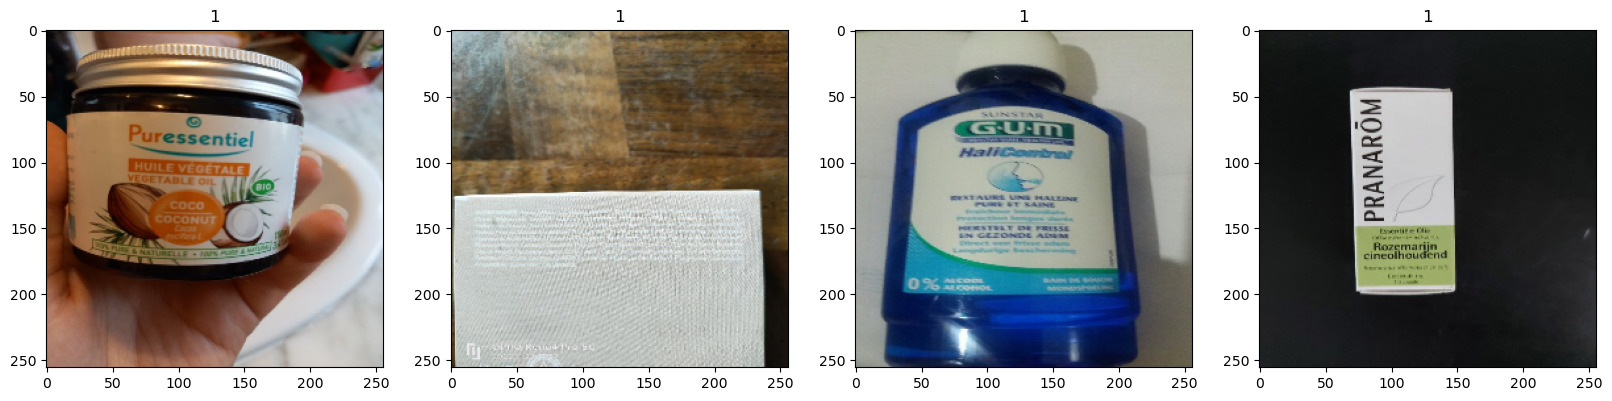

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
data.as_numpy_iterator().next()

(array([[[[3.30327637e-02, 1.73464902e-02, 5.58178453e-03],
          [2.83721928e-02, 1.26859182e-02, 9.21211962e-04],
          [3.13282087e-02, 1.56419352e-02, 3.87722836e-03],
          ...,
          [5.01407683e-01, 6.07290030e-01, 6.89278603e-01],
          [4.61353183e-01, 5.65393150e-01, 6.40824139e-01],
          [4.52083319e-01, 5.38357854e-01, 6.20710790e-01]],
 
         [[2.74509806e-02, 1.17647061e-02, 0.00000000e+00],
          [2.74509806e-02, 1.17647061e-02, 0.00000000e+00],
          [2.74509806e-02, 1.17647061e-02, 0.00000000e+00],
          ...,
          [5.17095566e-01, 6.26894653e-01, 7.13164330e-01],
          [5.05055130e-01, 6.07429564e-01, 6.96798384e-01],
          [4.88893986e-01, 5.93949139e-01, 6.68872535e-01]],
 
         [[3.10951974e-02, 1.54089238e-02, 3.64421774e-03],
          [3.51514034e-02, 1.94651280e-02, 7.70042278e-03],
          [3.46128568e-02, 1.89265832e-02, 7.16187712e-03],
          ...,
          [5.40387154e-01, 6.64422929e-01, 7.6317

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
train_size

918

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
create_dataset()

100%|██████████| 39962/39962 [08:31<00:00, 78.19it/s]


In [11]:
random.shuffle(training_data)

In [12]:
X = []
y = []

In [13]:
for features,label in training_data:
    X.append(features)
    y.append(label)

In [14]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [15]:
pickle_out = open("features3and-1.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("labels3and-1.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [3]:
pickle_in = open("features3and-1.pickle","rb")
features = pickle.load(pickle_in)
features.shape

pickle_in = open("labels3and-1.pickle","rb")
labels = pickle.load(pickle_in)
labels= np.array(labels)
labels.shape

(41978,)

Text(0.5, 1.0, '1')

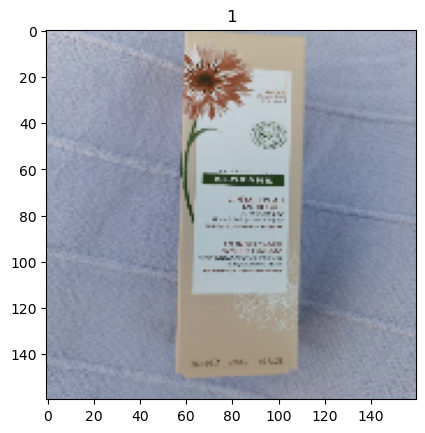

In [4]:
plt.figure()
plt.imshow(features[6666])
plt.title(CATEGORIES[labels[6666]])

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(160, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=75, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/75
918/918 [==============================] - 488s 530ms/step - loss: 0.0959 - accuracy: 0.9601 - val_loss: 0.0669 - val_accuracy: 0.9696
Epoch 2/75
918/918 [==============================] - 486s 528ms/step - loss: 0.0698 - accuracy: 0.9690 - val_loss: 0.0619 - val_accuracy: 0.9724
Epoch 3/75
918/918 [==============================] - 495s 539ms/step - loss: 0.0658 - accuracy: 0.9715 - val_loss: 0.0588 - val_accuracy: 0.9765
Epoch 4/75
918/918 [==============================] - 502s 546ms/step - loss: 0.0640 - accuracy: 0.9745 - val_loss: 0.0657 - val_accuracy: 0.9697
Epoch 5/75
918/918 [==============================] - 499s 543ms/step - loss: 0.0571 - accuracy: 0.9770 - val_loss: 0.0563 - val_accuracy: 0.9775
Epoch 6/75
918/918 [==============================] - 500s 543ms/step - loss: 0.0459 - accuracy: 0.9820 - val_loss: 0.0602 - val_accuracy: 0.9761
Epoch 7/75
918/918 [==============================] - 507s 552ms/step - loss: 0.0375 - accuracy: 0.9856 - val_loss: 0.0694 -

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train = X_train.astype("float32") / 127.5 -1
X_test = X_test.astype("float32") / 127.5 -1
X_val = X_val.astype("float32") / 127.5 -1

X_train1=np.array(X_train)
y_train1=np.array(y_train)
X_val1=np.array(X_val)
y_val1=np.array(y_val)

In [12]:
hist = model.fit(X_train1,y_train1, epochs=10, validation_data=(X_val1, y_val1), callbacks=[tensorboard_callback])

Epoch 1/10
735/735 [==============================] - 133s 180ms/step - loss: 0.0898 - accuracy: 0.9633 - val_loss: 0.0571 - val_accuracy: 0.9781
Epoch 2/10
735/735 [==============================] - 123s 167ms/step - loss: 0.0643 - accuracy: 0.9738 - val_loss: 0.0645 - val_accuracy: 0.9685
Epoch 3/10
735/735 [==============================] - 129s 175ms/step - loss: 0.0589 - accuracy: 0.9769 - val_loss: 0.0537 - val_accuracy: 0.9762
Epoch 4/10
735/735 [==============================] - 121s 164ms/step - loss: 0.0514 - accuracy: 0.9813 - val_loss: 0.0554 - val_accuracy: 0.9750
Epoch 5/10
735/735 [==============================] - 121s 164ms/step - loss: 0.0437 - accuracy: 0.9849 - val_loss: 0.0554 - val_accuracy: 0.9792
Epoch 6/10
735/735 [==============================] - 120s 163ms/step - loss: 0.0337 - accuracy: 0.9887 - val_loss: 0.0619 - val_accuracy: 0.9786
Epoch 7/10
735/735 [==============================] - 122s 166ms/step - loss: 0.0257 - accuracy: 0.9913 - val_loss: 0.0751 -

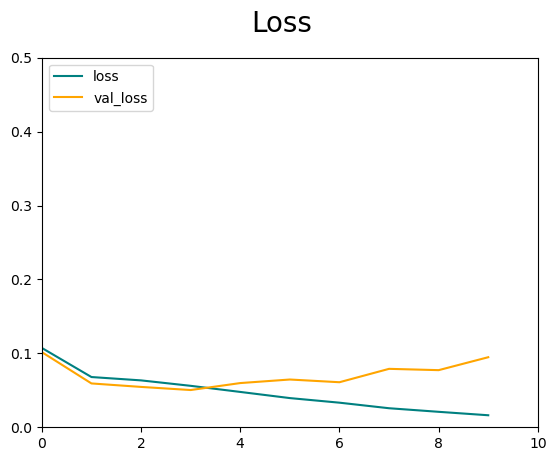

In [81]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.axis([0, 10, 0, 0.5])
plt.show()

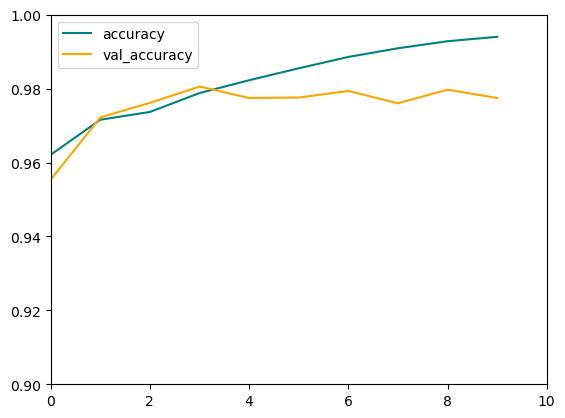

In [82]:
ig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.axis([0, 10, 0.9, 1])
plt.show()

In [23]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: name 'test' is not defined

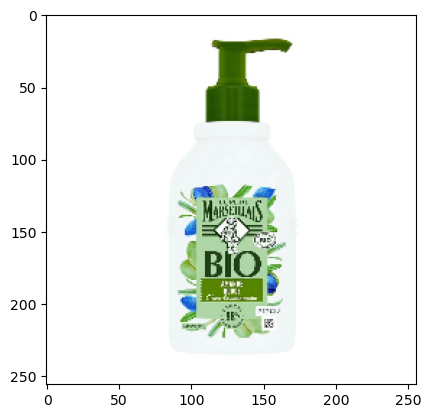

1/1 [==============================] - 0s 22ms/step
Prédiction : 0.7417709231376648
C'est un cosmétique


In [124]:
path1 = r'C:\Users\malek\Desktop\savon.jpg'


img = cv2.imread(path1)

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

k = model.predict(np.expand_dims(resize/255, 0))

print('Prédiction : {}'.format(k[0][0]))

if k[0][0]>0.5 :
    print("C'est un cosmétique")
elif k[0][0]<0.5 : 
    print("Ce n'est pas un cosmétique")
else : 
    print('à décider')
    

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/flatten_2/Reshape' defined at (most recent call last):
    File "C:\Users\malek\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\malek\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\malek\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\malek\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\malek\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\malek\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\malek\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\malek\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\malek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\malek\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\malek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\malek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\malek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\malek\AppData\Local\Temp\ipykernel_21744\3403329716.py", line 1, in <module>
      k = model.predict(np.expand_dims(img/255, 0))
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\malek\anaconda3\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_2/flatten_2/Reshape'
Input to reshape is a tensor with 100352 values, but the requested shape requires a multiple of 14400
	 [[{{node sequential_2/flatten_2/Reshape}}]] [Op:__inference_predict_function_91634]

In [97]:
from tensorflow.keras.models import load_model

In [98]:
model.save(os.path.join('models','cos_with_3and-1_img.h5'))

In [99]:
new_model = load_model(os.path.join('models','cos_with_3and-1_img.h5'))

In [100]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 55ms/step


array([[0.9999671]], dtype=float32)

In [125]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [126]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 104ms/step


In [127]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.99172723, shape=(), dtype=float32) tf.Tensor(0.987026, shape=(), dtype=float32) tf.Tensor(0.9797233, shape=(), dtype=float32)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

MemoryError: Unable to allocate 1.46 GiB for an array with shape (20384, 160, 160, 3) and data type uint8

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)
X_train = X_train.astype("float32") / 127.5 -1
X_test = X_test.astype("float32") / 127.5 -1
X_val = X_val.astype("float32") / 127.5 -1

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')


In [47]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [9]:
sortie_conv =  tf.keras.Sequential()
sortie_conv.add(tf.keras.layers.GlobalAveragePooling2D())
sortie_conv.add(tf.keras.layers.Dense(1))

In [10]:
base_model.trainable = False

In [11]:
model = tf.keras.Sequential([base_model,sortie_conv,])

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential (Sequential)     (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
X_train1=np.array(X_train)
y_train1=np.array(y_train)
X_val1=np.array(X_val)
y_val1=np.array(y_val)

In [14]:
history = model.fit(
    X_train1,
    y_train1,
    batch_size=128,
    epochs=8,
    validation_data=(X_val1, y_val1),
)

Epoch 1/8
335/335 [==============================] - 302s 887ms/step - loss: 0.2155 - accuracy: 0.9121 - val_loss: 0.1870 - val_accuracy: 0.9262
Epoch 2/8
335/335 [==============================] - 288s 860ms/step - loss: 0.1751 - accuracy: 0.9309 - val_loss: 0.1814 - val_accuracy: 0.9262
Epoch 3/8
335/335 [==============================] - 289s 864ms/step - loss: 0.1671 - accuracy: 0.9362 - val_loss: 0.1769 - val_accuracy: 0.9332
Epoch 4/8
335/335 [==============================] - 304s 908ms/step - loss: 0.1625 - accuracy: 0.9375 - val_loss: 0.1794 - val_accuracy: 0.9271
Epoch 5/8
335/335 [==============================] - 326s 975ms/step - loss: 0.1591 - accuracy: 0.9386 - val_loss: 0.1757 - val_accuracy: 0.9323
Epoch 6/8
335/335 [==============================] - 362s 1s/step - loss: 0.1568 - accuracy: 0.9398 - val_loss: 0.1764 - val_accuracy: 0.9317
Epoch 7/8
335/335 [==============================] - 360s 1s/step - loss: 0.1552 - accuracy: 0.9413 - val_loss: 0.1746 - val_accuracy

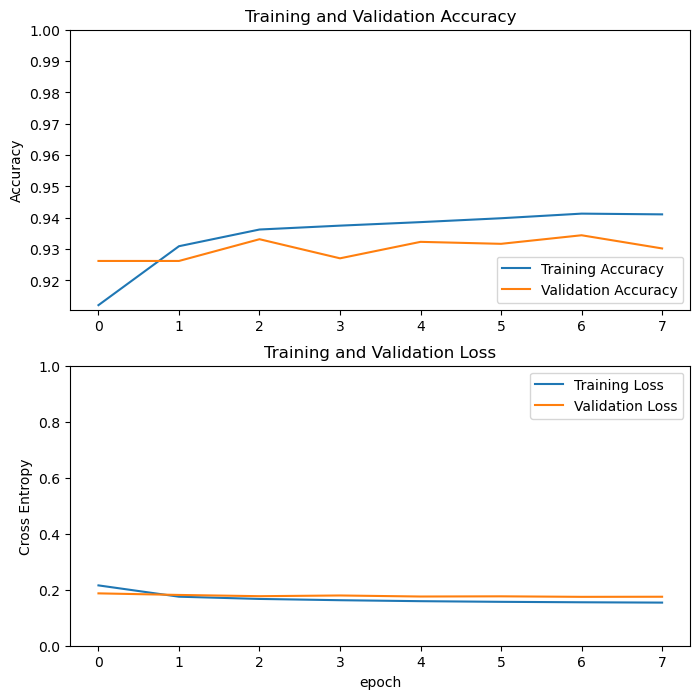

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

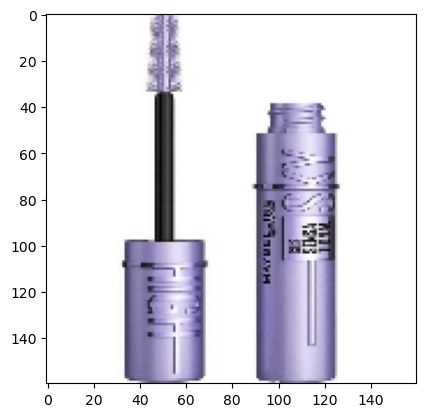

In [22]:
path1 = r'C:\Users\malek\Desktop\abc.jpg'

try:
    img1 = cv2.imread(path1)  # Conversion des images en array
    new_array1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))  # Redimensionner les images à la même taille
except Exception as e: 
    pass

new_array1=np.array(new_array1)
plt.figure()
plt.imshow(new_array1)

images_list = []
images_list.append(np.array(new_array1))
x = np.asarray(images_list)

In [71]:
prediction = model.predict({'mobilenetv2_1.00_160_input': x })
print(prediction)

1/1 [==============================] - 0s 31ms/step
[[0.8226497]]
